# Restaurant Comment Analysis

<img src='https://assets.simpleviewcms.com/simpleview/image/fetch/c_pad,h_600,q_75,w_1122/https://lasvegas.simpleviewcrm.com/images/listings/original_Bacchanal-Buffet-at-Caesars-Palace.jpg'/>

### Importing Required Packages

In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
warnings.filterwarnings("ignore")

## Load the data

In [2]:
df = pd.read_csv('restaurant.csv')

## Remember

##### Things to consider when starting an NLP project

* Convert everything to lowercase
* remove punctuation marks
* remove digits
* remove line breaks \n
*  stopwords remove unnecessary words
* Tokenize
*  Remove suffixes and find roots with lemma and stemma
* Vectorize

## EDA - Exploratory Data Analysis

In [3]:
df.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,2370338,_WTGv5XnA-qb_XD1D7Z0jg,6PgdGb3HrZdsfl2GiULo8w,RESDUcs7fIiihp38-d6_6g,5,0,1,0,After getting food poisoning at the Palms hote...,2012-12-04 03:10:18
1,2370357,JlNnsvMPLK_1-X2hwzK24w,IS9yw8P2uAPBX6FNLLX4KA,RESDUcs7fIiihp38-d6_6g,4,39,21,29,"""A feast worthy of Gods""\n\nBaccarnal Buffet i...",2014-01-17 00:50:50
2,2370373,hBkoWffORRb6aqKhC_Li2A,uZdFsE_aHbFBChgN6Xa8tw,RESDUcs7fIiihp38-d6_6g,4,1,1,1,The crab legs are better than the ones at Wick...,2015-06-08 18:03:09
3,2370411,rbkxvrgZg5kdCL2a66QYmA,8ZWJNAEWsymXDzKx3B0tTQ,RESDUcs7fIiihp38-d6_6g,1,0,0,0,Not worth it! Too salty food and expensive! Th...,2016-12-19 16:15:29
4,2370500,5tw_pedoHVi9bgeiBNsISg,E0sm4Ve7ifanFYeQMcV8Eg,RESDUcs7fIiihp38-d6_6g,5,0,0,0,I would give this infinite stars if I could. M...,2015-07-28 07:13:17


In [4]:
# Drop the columns that are not required
df = df.drop(['Unnamed: 0','business_id', 'review_id', 'user_id'], axis=1)

In [5]:
df.shape

(10417, 6)

In [6]:
df.sample(5)

,stars,useful,funny,cool,text,date
4469,5,2,1,1,"If you haven't been to a Vegas buffet before, ...",2018-03-21 20:59:18
6041,3,1,0,0,You know when you get all amped up to go to on...,2014-04-16 02:29:29
2346,3,1,1,0,First off...go to the computerized screen to g...,2014-10-16 23:43:47
6749,4,0,0,0,The reason I'm giving this 4stars was only bec...,2016-06-19 23:40:27
3566,4,0,0,1,Bacchanal Buffet is a $17 million project that...,2015-03-25 21:22:13


In [7]:
df.isnull().sum()

stars     0
useful    0
funny     0
cool      0
text      0
date      0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10417 entries, 0 to 10416
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   stars   10417 non-null  int64 
 1   useful  10417 non-null  int64 
 2   funny   10417 non-null  int64 
 3   cool    10417 non-null  int64 
 4   text    10417 non-null  object
 5   date    10417 non-null  object
dtypes: int64(4), object(2)
memory usage: 488.4+ KB


In [9]:
df.describe()

,stars,useful,funny,cool
count,10417.000000,10417.000000,10417.000000,10417.000000
mean,3.777671,1.419603,0.640875,0.759720
std,1.331451,4.875888,3.347964,4.125847
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,176.000000,159.000000,172.000000


In [10]:
df['date'] = pd.to_datetime(df['date'])

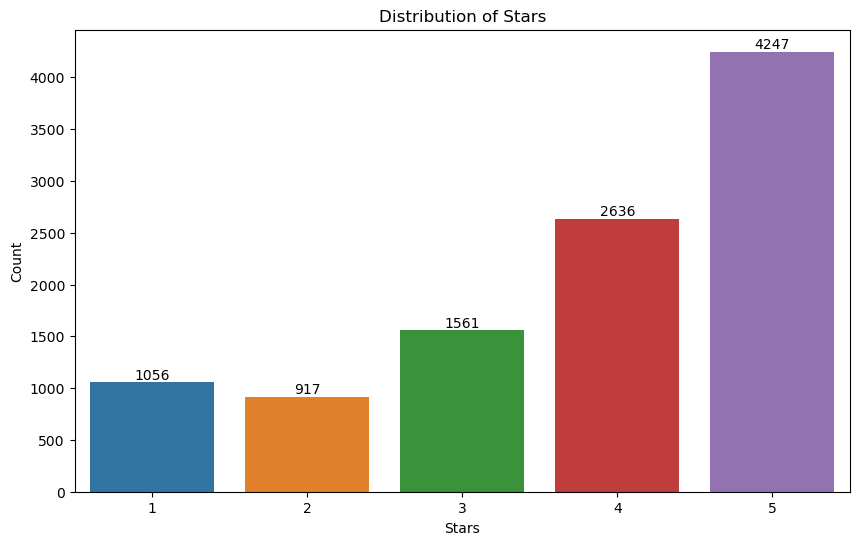

In [13]:
# Distribution of Stars
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=df['stars'])
ax.bar_label(ax.containers[0])
plt.title('Distribution of Stars')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.show()


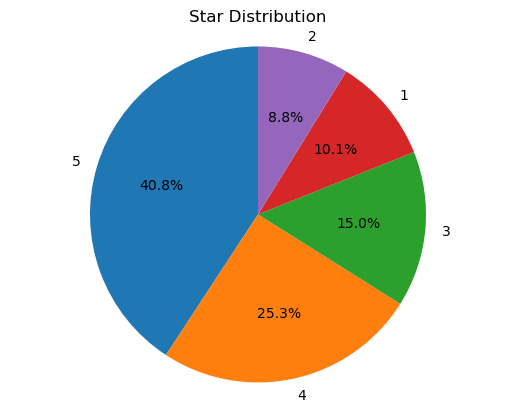

In [35]:
stars_counts = df['stars'].value_counts()
labels = stars_counts.index
sizes = stars_counts.values

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Star Distribution')
plt.show()

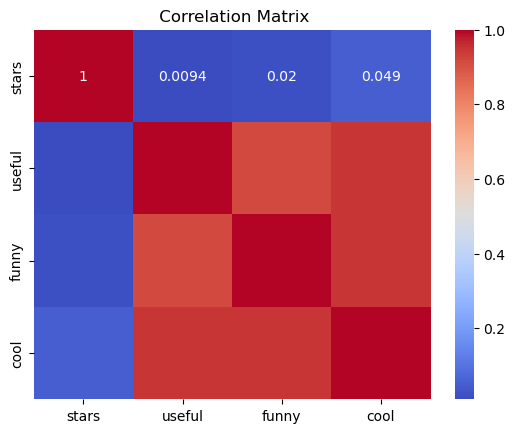

In [14]:
# Correlation Matrix
correlation = df.corr(numeric_only=True)
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title(' Correlation Matrix')
plt.show()

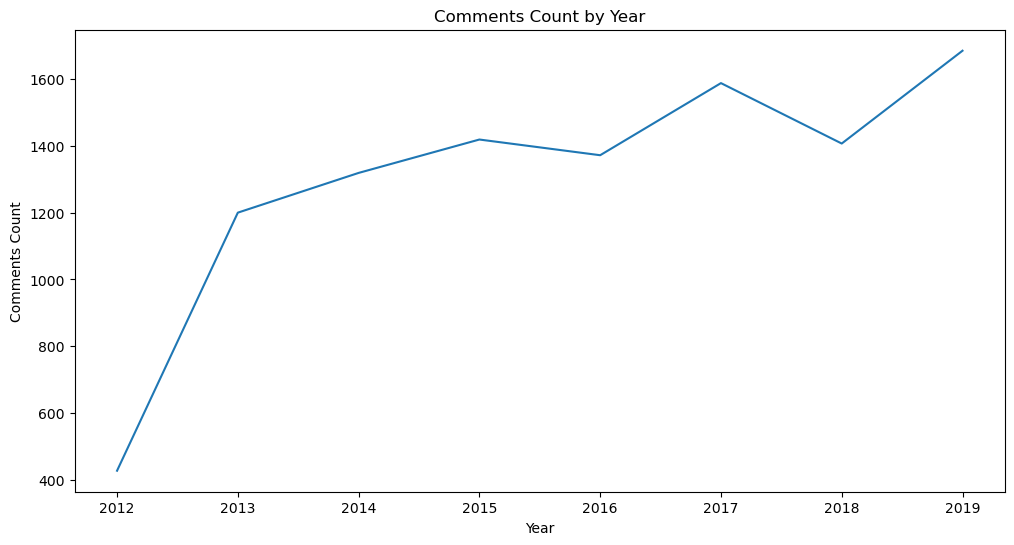

In [18]:
# Comments Count by Year

df['year'] = df['date'].dt.year
yearly_reviews = df.groupby('year').size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='count', data=yearly_reviews)
plt.title('Comments Count by Year')
plt.xlabel('Year')
plt.ylabel('Comments Count')
plt.show()

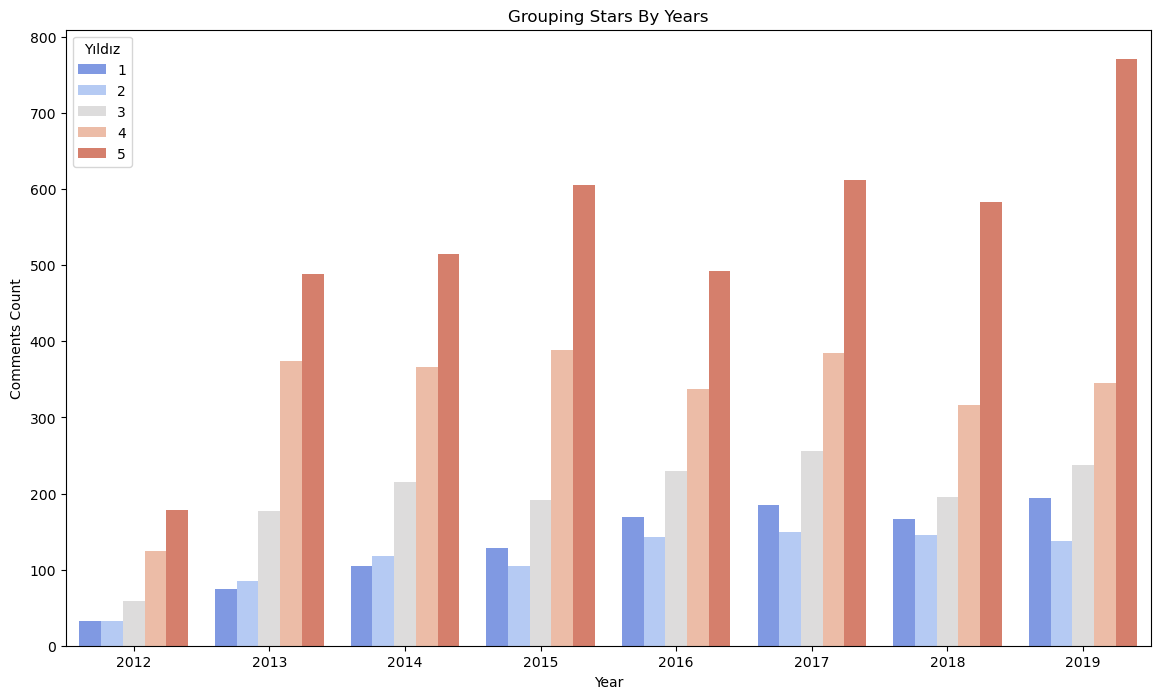

In [19]:
# Grouping stars by years
yearly_star_counts = df.groupby(['year', 'stars']).size().reset_index(name='count')
yearly_star_counts['year'] = yearly_star_counts['year'].astype(str)
yearly_star_counts['stars'] = yearly_star_counts['stars'].astype(str)

plt.figure(figsize=(14, 8))
sns.barplot(x='year', y='count', hue='stars', data=yearly_star_counts, palette='coolwarm')
plt.title('Grouping Stars By Years')
plt.xlabel('Year')
plt.ylabel('Comments Count')
plt.legend(title='Yıldız')
plt.show();

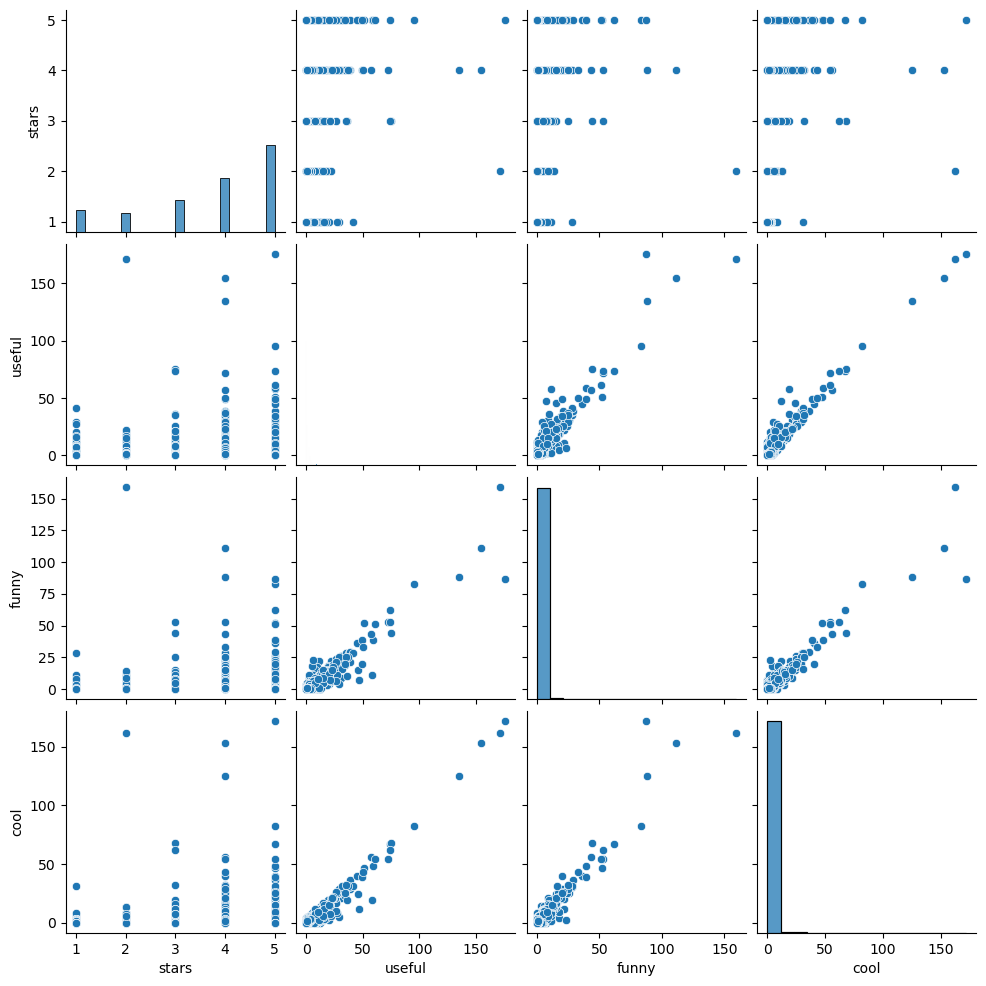

In [17]:
sns.pairplot(df[['stars', 'useful', 'funny', 'cool']])
plt.show()

### Sentiment Column
 A sentiment column was created according to the stars.
* 1-2 stars negative,
* 3 stars neutral, 
* 4-5 stars positive were marked.

In [11]:
# add sentiment column
df['sentiment'] = df['stars'].apply(lambda x: 'positive' if x > 3 else 'neutral' if x == 3 else 'negative')
df = df.reindex(columns=['stars','sentiment'] + [col for col in df.columns if col != 'sentiment' and col != 'stars'])
df.sentiment = df.sentiment.astype('category')

In [12]:
df.sample(10)

,stars,sentiment,useful,funny,cool,text,date
1644,4,positive,0,0,0,I see a lot of hype for this place so I went h...,2018-07-10 01:47:53
9795,5,positive,8,1,3,AMAZING! Until last night I told everyone I me...,2012-09-12 16:47:35
8341,5,positive,0,0,0,"I give this buffet 4.5, but rounding up since ...",2018-12-24 11:45:26
401,5,positive,1,0,0,The line was long and we waited for 2 hours bu...,2015-08-19 22:22:50
10286,5,positive,0,0,0,Love it here!! Great choices and great atmosph...,2019-11-10 23:13:48
4511,5,positive,1,1,1,Best buffet in Vegas by far...\n\nTotally wort...,2015-08-02 19:59:28
7945,3,neutral,0,0,0,This is the best buffet I have eaten at in LV....,2019-12-06 18:07:21
2946,4,positive,3,0,0,"In terms of overall selection and quality, Bac...",2016-06-28 17:45:43
9626,5,positive,0,0,0,I want to preface this review. I ate at the Ba...,2019-04-25 05:08:23
7238,2,negative,1,0,0,(Note that I'm rating 2 stars which I think is...,2018-11-04 16:40:48


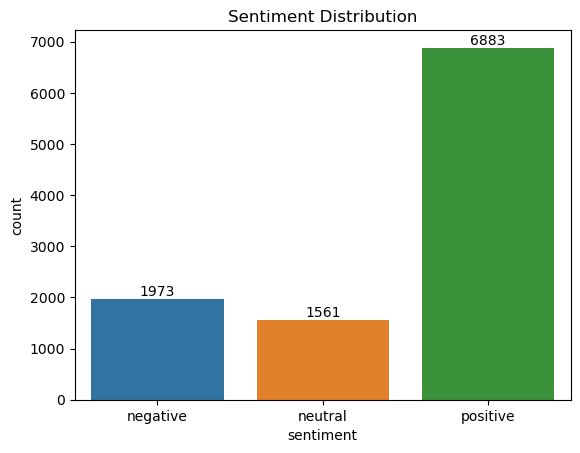

In [13]:
# Sentiment Distribution
ax = sns.countplot(x='sentiment', data=df)
ax.bar_label(ax.containers[0])
plt.title('Sentiment Distribution');

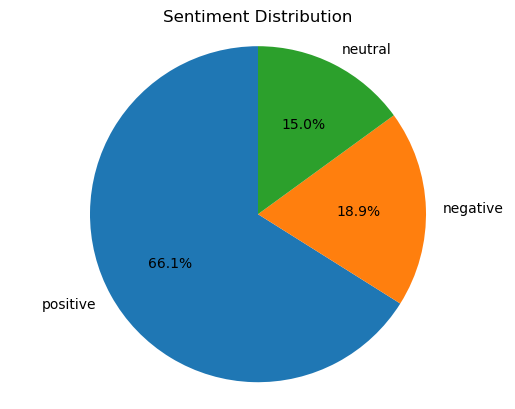

In [14]:
# Sentiment Distribution
sentiment_counts = df['sentiment'].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Sentiment Distribution')
plt.show()

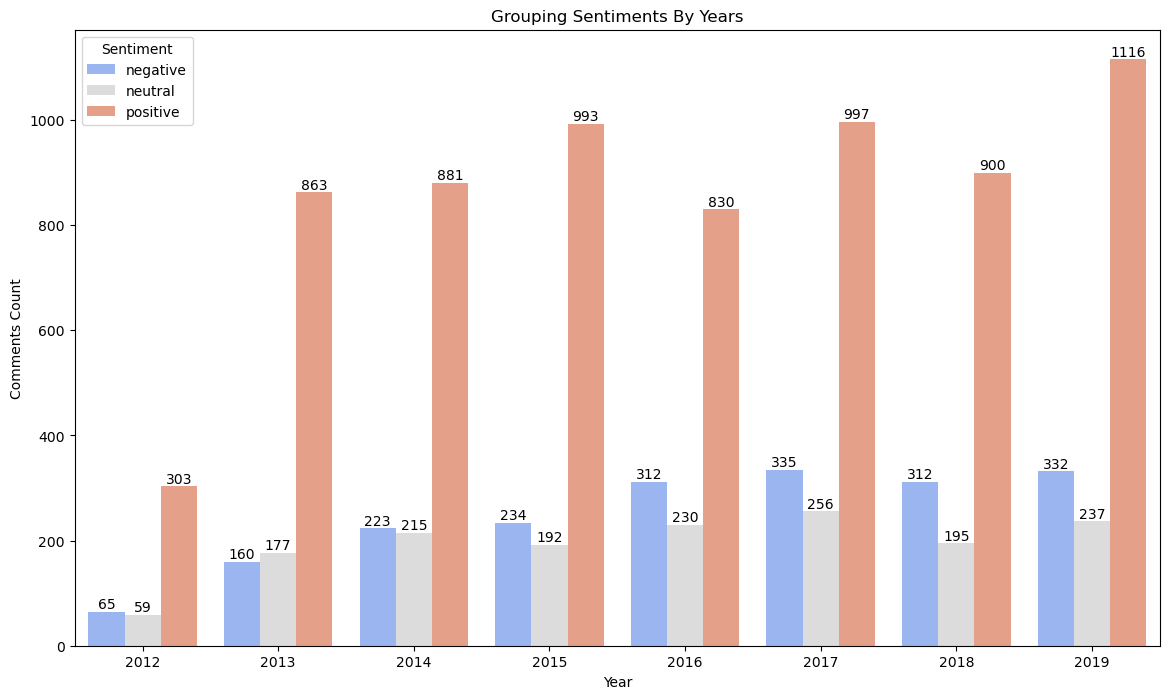

In [20]:
# Grouping sentiments by years
yearly_star_counts = df.groupby(['year', 'sentiment']).size().reset_index(name='count')
yearly_star_counts['year'] = yearly_star_counts['year'].astype(str)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='year', y='count', hue='sentiment', data=yearly_star_counts, palette='coolwarm')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.title('Grouping Sentiments By Years')
plt.xlabel('Year')
plt.ylabel('Comments Count')
plt.legend(title='Sentiment')
plt.show();

In [26]:
def wc(data, bgcolor):
    plt.figure(figsize = (10,10))
    mask = np.array(Image.open('cloud.png'))
    wc = WordCloud(background_color = bgcolor, stopwords= STOPWORDS, mask=mask)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [31]:
negative_comments = df[df['sentiment'] == 'negative']['text']
positive_comments = df[df['sentiment'] == 'positive']['text']
one_star_comments = df[df['stars'] == 1]['text']
five_star_comments = df[df['stars'] == 5]['text']

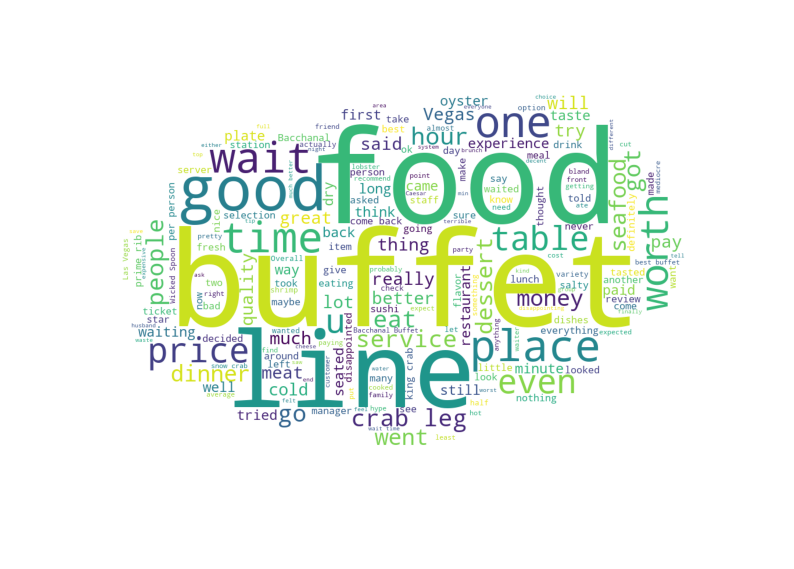

In [28]:
wc(negative_comments, 'white')

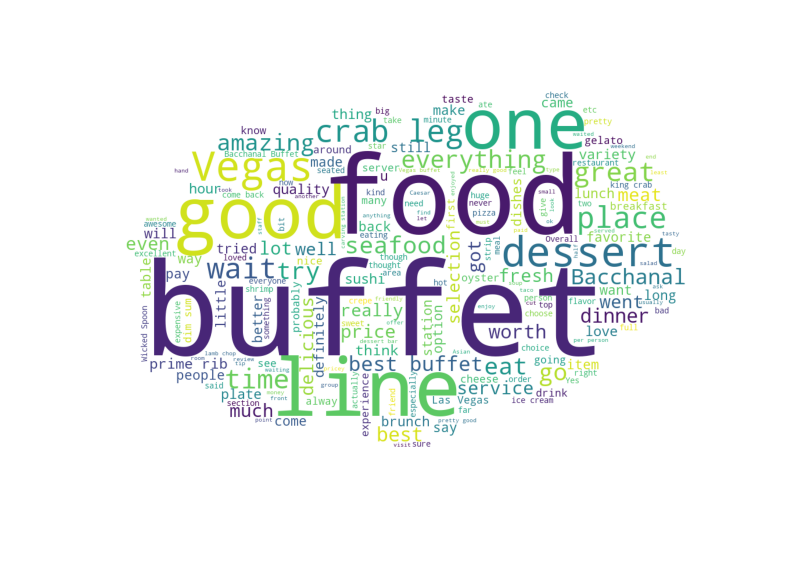

In [29]:
wc(positive_comments, 'white')

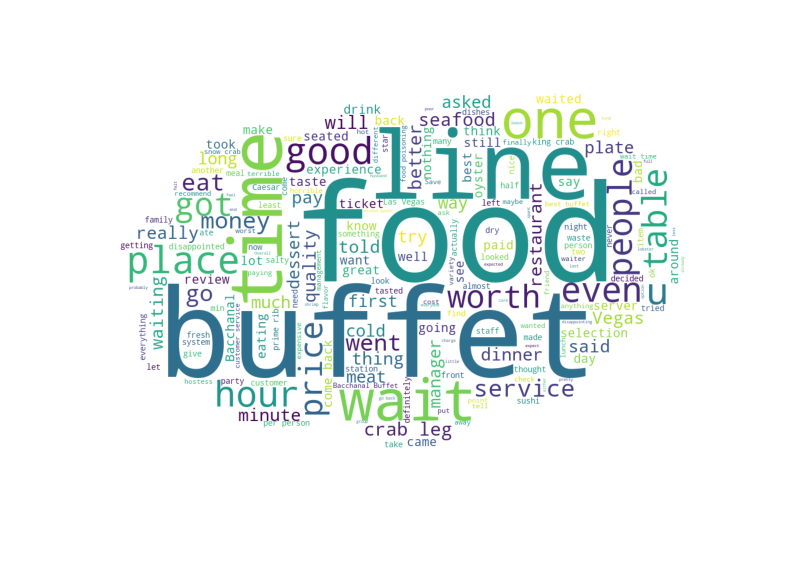

In [32]:
wc(one_star_comments, 'white')


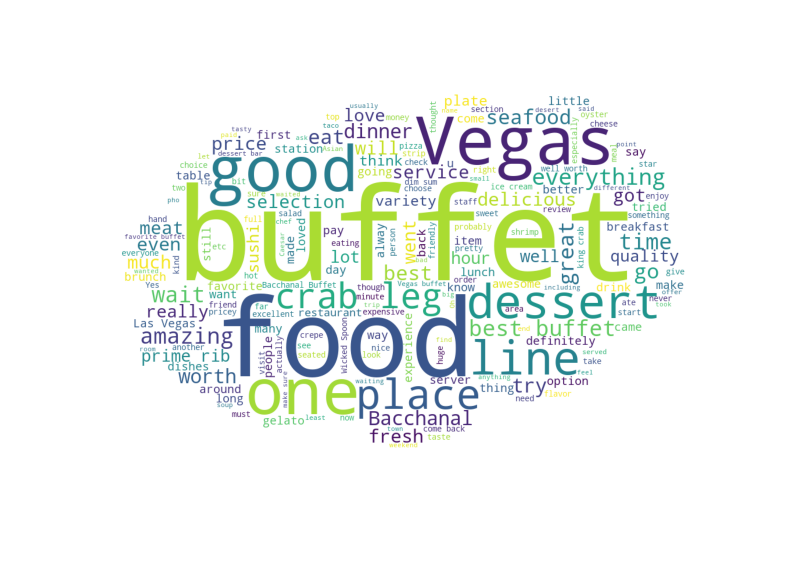

In [33]:
wc(five_star_comments, 'white')


### Text Preprocessing

In [20]:
df.head(2)

,stars,sentiment,useful,funny,cool,text,date,year
0,5,positive,0,1,0,After getting food poisoning at the Palms hote...,2012-12-04 03:10:18,2012
1,4,positive,39,21,29,"""A feast worthy of Gods""\n\nBaccarnal Buffet i...",2014-01-17 00:50:50,2014


In [21]:
df.text = df.text.str.lower()
df.text = df.text.str.replace('[^\w\s]','' , regex=True)
df.text = df.text.str.replace('\n','')
df.text = df.text.str.replace('\d+' , '' , regex=True)

In [22]:
df.head(2)

,stars,sentiment,useful,funny,cool,text,date,year
0,5,positive,0,1,0,after getting food poisoning at the palms hote...,2012-12-04 03:10:18,2012
1,4,positive,39,21,29,a feast worthy of godsbaccarnal buffet in caes...,2014-01-17 00:50:50,2014


### Detect Language

In [23]:
# detect language
from langdetect import detect
df['language'] = df['text'].apply(lambda x: detect(x))

In [24]:
df.language.value_counts()

language
en       10374
es          10
zh-cn        7
ja           7
ko           5
fr           5
de           4
da           2
zh-tw        1
pt           1
sl           1
Name: count, dtype: int64

In [25]:
# Get non-English ones
df[df['language'] != 'en'].language.value_counts()

language
es       10
zh-cn     7
ja        7
ko        5
fr        5
de        4
da        2
zh-tw     1
pt        1
sl        1
Name: count, dtype: int64

In [26]:
df[df['language'] != 'en'].shape

(43, 9)

In [27]:
df = df[df['language'] == 'en']

### Sentiment Analysis

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

def algo_test(x, y):
    bnb = BernoulliNB()
    lr = LogisticRegression()
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    gbc = GradientBoostingClassifier()
    knc = KNeighborsClassifier()
    mnb = MultinomialNB()
    ada = AdaBoostClassifier()
    
    algos = [bnb, lr, dt, rf, gbc, knc, mnb, ada]
    algo_names = ['BernoulliNB', 'LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'MultinomialNB', 'AdaBoostClassifier']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
    
    best_accuracy = 0
    best_algo_index = 0
    
    for i, algo in enumerate(algos):
        p = algo.fit(x_train, y_train).predict(x_test)
        acc = accuracy_score(p, y_test)
        if acc > best_accuracy:
            best_accuracy = acc
            best_algo_index = i
    
    best_algo_name = algo_names[best_algo_index]
    best_algo = algos[best_algo_index]
    p = best_algo.fit(x_train, y_train).predict(x_test)
    
    print(f'Best Algorithm: {best_algo_name}')
    print('Confusion Matrix:\n', confusion_matrix(p, y_test))
    print('Classification Report:\n', classification_report(p, y_test))
    print('Accuracy Score:\n', accuracy_score(p, y_test))


In [29]:
from nltk.stem import PorterStemmer
pr = PorterStemmer()

def lemmafn (text):
    words = TextBlob(text).words
    return [pr.stem(word) for word in words]    

In [35]:
# Without any preprocessing
vect = CountVectorizer()
x = df['text']
y = df['sentiment']
x = vect.fit_transform(x)
algo_test(x,y)

Best Algorithm: LogisticRegression
Confusion Matrix:
 [[ 279   88   37]
 [  70  117   77]
 [  45  115 1247]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.69      0.70       404
     neutral       0.37      0.44      0.40       264
    positive       0.92      0.89      0.90      1407

    accuracy                           0.79      2075
   macro avg       0.66      0.67      0.67      2075
weighted avg       0.81      0.79      0.80      2075

Accuracy Score:
 0.7918072289156627


In [31]:
# With Lemmatization and Stemming
vect = CountVectorizer(stop_words='english', ngram_range=(1,2), analyzer=lemmafn)
x = df['text']
y = df['sentiment']
x = vect.fit_transform(x)
algo_test(x,y)

Best Algorithm: LogisticRegression
Confusion Matrix:
 [[ 287   93   38]
 [  64  119   77]
 [  43  108 1246]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.69      0.71       418
     neutral       0.37      0.46      0.41       260
    positive       0.92      0.89      0.90      1397

    accuracy                           0.80      2075
   macro avg       0.67      0.68      0.67      2075
weighted avg       0.81      0.80      0.80      2075

Accuracy Score:
 0.796144578313253


In [32]:
# With Lemmatization and Stemming and without ngram
vect = CountVectorizer(stop_words='english', analyzer=lemmafn)
x = df['text']
y = df['sentiment']
x = vect.fit_transform(x)
algo_test(x,y)

Best Algorithm: LogisticRegression
Confusion Matrix:
 [[ 287   93   38]
 [  64  119   77]
 [  43  108 1246]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.69      0.71       418
     neutral       0.37      0.46      0.41       260
    positive       0.92      0.89      0.90      1397

    accuracy                           0.80      2075
   macro avg       0.67      0.68      0.67      2075
weighted avg       0.81      0.80      0.80      2075

Accuracy Score:
 0.796144578313253


In [33]:
# with tfidf
tfidf_vect = TfidfVectorizer()
x = df['text']
y = df['sentiment']
x = tfidf_vect.fit_transform(x)
algo_test(x,y)

Best Algorithm: LogisticRegression
Confusion Matrix:
 [[ 291   79   21]
 [  36   88   21]
 [  67  153 1319]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.74      0.74      0.74       391
     neutral       0.28      0.61      0.38       145
    positive       0.97      0.86      0.91      1539

    accuracy                           0.82      2075
   macro avg       0.66      0.74      0.68      2075
weighted avg       0.88      0.82      0.84      2075

Accuracy Score:
 0.8183132530120482


In [34]:
# with tfidf with ngram
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
x = df['text']
y = df['sentiment']
x = tfidf_vect.fit_transform(x)
algo_test(x,y)

Best Algorithm: LogisticRegression
Confusion Matrix:
 [[ 259   66   11]
 [  19   54   11]
 [ 116  200 1339]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.66      0.77      0.71       336
     neutral       0.17      0.64      0.27        84
    positive       0.98      0.81      0.89      1655

    accuracy                           0.80      2075
   macro avg       0.60      0.74      0.62      2075
weighted avg       0.90      0.80      0.83      2075

Accuracy Score:
 0.796144578313253


In [21]:
#negative one word
from collections import Counter
negative_comments = df[df['sentiment'] == 'negative']['text']

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(negative_comments)

feature_names = tfidf.get_feature_names_out()
tfidf_sums = tfidf_matrix.sum(axis=0).A1
tfidf_scores = dict(zip(feature_names, tfidf_sums))

top_words_negative = Counter(tfidf_scores).most_common(10)
top_words_negative

[('food', 106.03339700201504),
 ('buffet', 96.2130694244913),
 ('line', 72.6918093811067),
 ('good', 67.39933862807722),
 ('wait', 65.71737887135765),
 ('time', 57.15798493052472),
 ('crab', 56.6829690038089),
 ('just', 53.36206712298385),
 ('place', 50.428694911567504),
 ('worth', 49.990650652870436)]

In [22]:
# negative bigrams
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

negative_comments = df[df['sentiment'] == 'negative']['text']

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(2, 2))
tfidf_matrix = tfidf.fit_transform(negative_comments)

feature_names = tfidf.get_feature_names_out()
tfidf_sums = tfidf_matrix.sum(axis=0).A1
tfidf_scores = dict(zip(feature_names, tfidf_sums))

top_bigrams_negative = Counter(tfidf_scores).most_common(10)
top_bigrams_negative

[('crab legs', 22.13242345196523),
 ('prime rib', 13.207554901501744),
 ('king crab', 12.04886993527975),
 ('wicked spoon', 10.53612655038859),
 ('food good', 9.490946391000621),
 ('quality food', 9.261369997266453),
 ('wait line', 8.87695262910119),
 ('las vegas', 8.671058258714735),
 ('buffet vegas', 8.60711691018533),
 ('bacchanal buffet', 7.951282126334509)]

In [23]:
# negative trigrams

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

negative_comments = df[df['sentiment'] == 'negative']['text']

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(3, 3))
tfidf_matrix = tfidf.fit_transform(negative_comments)

feature_names = tfidf.get_feature_names_out()
tfidf_sums = tfidf_matrix.sum(axis=0).A1
tfidf_scores = dict(zip(feature_names, tfidf_sums))

top_trigrams_negative = Counter(tfidf_scores).most_common(10)
top_trigrams_negative

[('king crab legs', 5.242354614409015),
 ('best buffet vegas', 3.8311542048133522),
 ('snow crab legs', 3.2719975072421295),
 ('buffet las vegas', 2.565059952463353),
 ('don waste money', 2.535187113562513),
 ('got food poisoning', 2.4254163140890697),
 ('definitely worth price', 2.188453467673815),
 ('waste time money', 1.9573969366306712),
 ('wicked spoon better', 1.9442515826140994),
 ('don waste time', 1.8144725480196797)]

In [24]:
#positive one word
from collections import Counter
positive_comments = df[df['sentiment'] == 'positive']['text']

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(positive_comments)

feature_names = tfidf.get_feature_names_out()
tfidf_sums = tfidf_matrix.sum(axis=0).A1
tfidf_scores = dict(zip(feature_names, tfidf_sums))

top_words_positive = Counter(tfidf_scores).most_common(10)
top_words_positive

[('buffet', 387.76243942796896),
 ('food', 338.9990004191209),
 ('good', 258.62928553356943),
 ('vegas', 245.20616632120962),
 ('best', 236.18825433531396),
 ('great', 219.24491205888535),
 ('worth', 191.5257201737761),
 ('wait', 190.9590228255637),
 ('crab', 190.39663376724903),
 ('time', 185.27402019643816)]

In [25]:
# positive bigrams
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

positive_comments = df[df['sentiment'] == 'positive']['text']

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(2, 2))
tfidf_matrix = tfidf.fit_transform(positive_comments)

feature_names = tfidf.get_feature_names_out()
tfidf_sums = tfidf_matrix.sum(axis=0).A1
tfidf_scores = dict(zip(feature_names, tfidf_sums))

top_bigrams_positive = Counter(tfidf_scores).most_common(10)
top_bigrams_positive

[('crab legs', 85.63820186396823),
 ('best buffet', 85.24313556177268),
 ('buffet vegas', 56.57797259441003),
 ('las vegas', 47.085443776308864),
 ('prime rib', 46.15588629097679),
 ('bacchanal buffet', 31.178361509418966),
 ('wicked spoon', 30.05481170695511),
 ('quality food', 28.92777827306948),
 ('dim sum', 28.861194074593126),
 ('king crab', 27.40841387110929)]

In [26]:
# positive trigramss
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

positive_comments = df[df['sentiment'] == 'positive']['text']

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(3, 3))
tfidf_matrix = tfidf.fit_transform(positive_comments)

feature_names = tfidf.get_feature_names_out()
tfidf_sums = tfidf_matrix.sum(axis=0).A1
tfidf_scores = dict(zip(feature_names, tfidf_sums))

top_trigrams_positive = Counter(tfidf_scores).most_common(10)
top_trigrams_positive

[('best buffet vegas', 34.48941081323067),
 ('buffet las vegas', 21.624615060472554),
 ('best buffet ve', 18.32781839352584),
 ('king crab legs', 17.36824082346451),
 ('best buffet las', 15.80783064543052),
 ('hands best buffet', 11.029941991029593),
 ('favorite buffet vegas', 10.340598899660986),
 ('best buffet strip', 10.177580601203154),
 ('far best buffet', 9.403708231615877),
 ('snow crab legs', 9.189162924491564)]